In [38]:
import pandas as pd
import numpy as np
import scanpy as sc
from statannot import add_stat_annotation
import random
import scipy
from scipy.stats import wilcoxon
from scipy.stats import rankdata
from scipy.stats import pearsonr, spearmanr
from scipy.stats import ranksums
from tqdm import tqdm
import os
from sklearn.neighbors import NearestNeighbors
from matplotlib import rcParams
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import matplotlib as mpl
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
warnings.filterwarnings('ignore')

In [39]:
sample_list = ['P01', 'P02', 'P03', 'P04', 'R06', 'P06', 'R02', 
               'R03', 'R08', 'P09', 'P11', 'R09', 'R12', 'R08','P12']
scRNA_sample_list = ['P01', 'P02', 'P03', 'P04', 'R06', 'P06', 'R02', 'R03', 'R08', 'P09',
                     'P11', 'R09', 'R12', 'R08','P12']
celltype_list = ['B', 'CD4T', 'CD8T', 'Endothelial', 'Fibroblast', 'Malignant', 'Mast', 'Myeloid', 'NK', 'Neutrophil', 'Plasmacyte', 'Tcycling', 'Treg', 'pDC']
sample_dict = dict(zip(sample_list, scRNA_sample_list))

Pri_list = ['P01','P02','P03','P06','P09','P11','P12','P04']
Rec_list = ['R06','R02','R08','R09','R12','YX496','R03']

path = 'E:\\datasets\\space\\'
file_list = os.listdir(path)

In [40]:
def calc_distance(adata_spatial, celltype1_list, celltype2_list, method='total'):
    
    location = pd.DataFrame(adata_spatial.obsm['spatial'], index = adata_spatial.obs.index)
    location1 = location.loc[celltype1_list,:]
    location2 = location.loc[celltype2_list,:]
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(location2)
    distances, indices = nbrs.kneighbors(location1)
    if  method=='mean':
        return distances, np.mean(distances)
    elif method=='median':
        return distances, np.median(distances)
    elif method=='total':
        dist_list = []
        for i in range(distances.shape[0]):
            dist_list.append(distances[i,0])
        return distances, dist_list

In [41]:
all_celltypes = ['DC1','DC2 CD1A','DC2 PLAC8','DC3','Macro CCL5','Macro ISG15','Macro MSR1','Macro SPP1','Macro TNFRSF9','Mono FCN1','pDC']
pri_distance = {}
rec_distance = {}
for k in tqdm(range(len(sample_list))):
    sample = sample_list[k]
    sc_sample = scRNA_sample_list[k]
    adata_st = sc.read_visium(path+sample)
    adata_st.var_names_make_unique()
    result = pd.read_csv('E:\\deconv\\SpaCET\\save\\'+sample+'_propMat.csv',index_col=0)
    result = result.T
    df_mal = result['Malignant']
    df_mal[df_mal>0.5] = 1
    df_mal[df_mal<=0.5] = 0
    Malignant_barcode_list = df_mal[df_mal==1].index
    
    spot_num = result.shape[0]
    spot_num_85 = int(spot_num*0.85)
    spot_num_15 = spot_num - spot_num_85 
    #random_distance = []
    #random_index = random.sample(range(spot_num), spot_num_15)
    #random_barcode_list = result.index[random_index]
    #dist_array, random_distance = calc_distance(adata_st, Malignant_barcode_list, random_barcode_list, method='total') 
    for celltype in all_celltypes:
        df_sorted = result[celltype].sort_values()
        df_top_15 = df_sorted[spot_num_85:]#select spots  with top 15% of celltype
        Myeloid_celltype_barcode_list = df_top_15.index
        dist_array, distance = calc_distance(adata_st, Myeloid_celltype_barcode_list, Malignant_barcode_list, method='total') 
        if scRNA_sample_list[k] in Pri_list:
            if celltype in pri_distance.keys():
                pri_distance[celltype].extend(distance)
            else:
                pri_distance[celltype] = distance
        else:
            if celltype in rec_distance.keys():
                rec_distance[celltype].extend(distance)
            else:
                rec_distance[celltype] = distance

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.41it/s]


In [42]:
for celltype in ['DC2 CD1A','DC2 PLAC8','Macro SPP1','Macro CCL5','Mono FCN1','Macro MSR1','Macro ISG15','Macro TNFRSF9']:
    pri_list = pri_distance[celltype]
    rec_list = rec_distance[celltype]
    p_value, sta = ranksums(pri_list, rec_list)
    print(celltype, p_value, sta)

DC2 CD1A 31.493980071060186 1.0502007989022057e-217
DC2 PLAC8 33.209650051904546 7.811739755074113e-242
Macro SPP1 28.212492934375234 4.109099056610424e-175
Macro CCL5 34.36423080649355 8.633992464332767e-259
Mono FCN1 30.597910614493067 1.3048508263027811e-205
Macro MSR1 39.54959411122013 0.0
Macro ISG15 33.466321590017 1.490014070339144e-245
Macro TNFRSF9 37.59413583116005 2.68028612873992e-309


In [43]:
for celltype in ['DC2 CD1A','DC2 PLAC8','Macro SPP1','Mono FCN1','Macro CCL5','Macro MSR1','Macro ISG15','Macro TNFRSF9']:
    pri_list = pri_distance[celltype]
    print(celltype, np.median(pri_list))

DC2 CD1A 117.00427342623003
DC2 PLAC8 199.82242116439286
Macro SPP1 200.0
Mono FCN1 200.0
Macro CCL5 200.6888138387389
Macro MSR1 200.6888138387389
Macro ISG15 200.0
Macro TNFRSF9 200.0


In [44]:
for celltype in ['DC2 CD1A','DC2 PLAC8','Macro SPP1','Mono FCN1','Macro CCL5','Macro MSR1','Macro ISG15','Macro TNFRSF9']:
    rec_list = rec_distance[celltype]
    print(celltype, np.median(rec_list))

DC2 CD1A 0.0
DC2 PLAC8 0.0
Macro SPP1 0.0
Mono FCN1 0.0
Macro CCL5 0.0
Macro MSR1 0.0
Macro ISG15 0.0
Macro TNFRSF9 0.0


In [45]:
df_pri = pd.DataFrame.from_dict(pri_distance)
df_rec = pd.DataFrame.from_dict(rec_distance)

In [46]:
df_list = []
for i in range(df_pri.shape[0]):
    for j in range(df_pri.shape[1]):
        celltype = df_pri.columns[j]
        dist = df_pri.iloc[i,j]
        df_list.append([celltype, dist, 'P'])
for i in range(df_rec.shape[0]):
    for j in range(df_rec.shape[1]):
        celltype = df_rec.columns[j]
        dist = df_rec.iloc[i,j]
        df_list.append([celltype, dist, 'R'])

In [47]:
dist_df = pd.DataFrame(df_list)
dist_df.columns = ['celltype','distance','type']

In [48]:
box_pairs = []
#all_celltypes = ['DC1','DC2 CD1A','DC2 PLAC8','DC3','Macro SPP1','Macro CCL5','Mono FCN1','Macro MSR1','Macro ISG15','Macro TNFRSF9','pDC']
for i in range(len(all_celltypes)):
    box_pairs.append(((all_celltypes[i], 'P'),(all_celltypes[i],'R')))

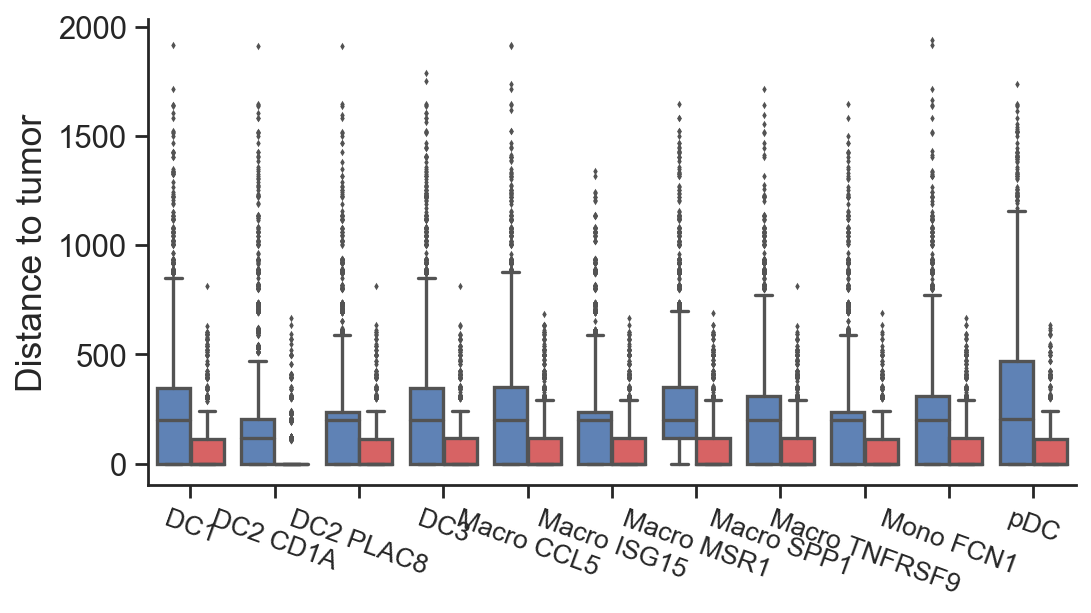

In [49]:
#sns.set(style="ticks")
my_pal ={'P':'#5f82b5','R':'#D76364'}
x = "celltype"
y = "distance"
data_boxplot = dist_df
#order = list(set(data_boxplot['cell_type']))
sc.set_figure_params(scanpy=True, fontsize=16)
sns.set(font='Arial',style="ticks")
with rc_context({'figure.figsize': (7, 4)}):
    ax = sns.boxplot(data=data_boxplot, x=x, y=data_boxplot['distance'], hue='type',fliersize=1, palette=my_pal, saturation=1)
    sns.despine(top = True, right = True)
    #ax.axes.set_title("Title",fontsize=16)
    ax.set(xlabel=None)
    ax.set_ylabel("Distance to tumor",fontsize=16)
    plt.legend([], frameon=False)
    ax.tick_params(labelsize=12, rotation=340,axis='x')
    ax.tick_params(labelsize=14, axis='y')
   # add_stat_annotation(ax, data=data_boxplot, x=x, y=y, hue='type',
    #                    box_pairs=box_pairs,
   #                    test='Mann-Whitney', loc='inside',
    #                    comparisons_correction = None,
    #                   )
plt.tight_layout()    
ax.get_figure().savefig('Myeloid_Malignant_Distance.svg')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Mono FCN1_P v.s. Mono FCN1_R: Mann-Whitney-Wilcoxon test two-sided, P_val=3.081e-226 U_stat=8.079e+06
pDC_P v.s. pDC_R: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=8.771e+06
Macro TNFRSF9_P v.s. Macro TNFRSF9_R: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=8.638e+06
DC2 CD1A_P v.s. DC2 CD1A_R: Mann-Whitney-Wilcoxon test two-sided, P_val=1.506e-265 U_stat=8.150e+06
DC1_P v.s. DC1_R: Mann-Whitney-Wilcoxon test two-sided, P_val=7.401e-294 U_stat=8.400e+06
DC2 PLAC8_P v.s. DC2 PLAC8_R: Mann-Whitney-Wilcoxon test two-sided, P_val=1.561e-276 U_stat=8.288e+06
DC3_P v.s. DC3_R: Mann-Whitney-Wilcoxon test two-sided, P_val=8.369e-280 U_stat=8.355e+06
Macro CCL5_P v.s. Macro CCL5_R: Mann-Whitney-Wilcoxon test two-sided, P_val=2.906e-274 U_stat=8.380e+06
Macro ISG15_P v.s. Macro ISG15_R: Mann-Whitney-Wil

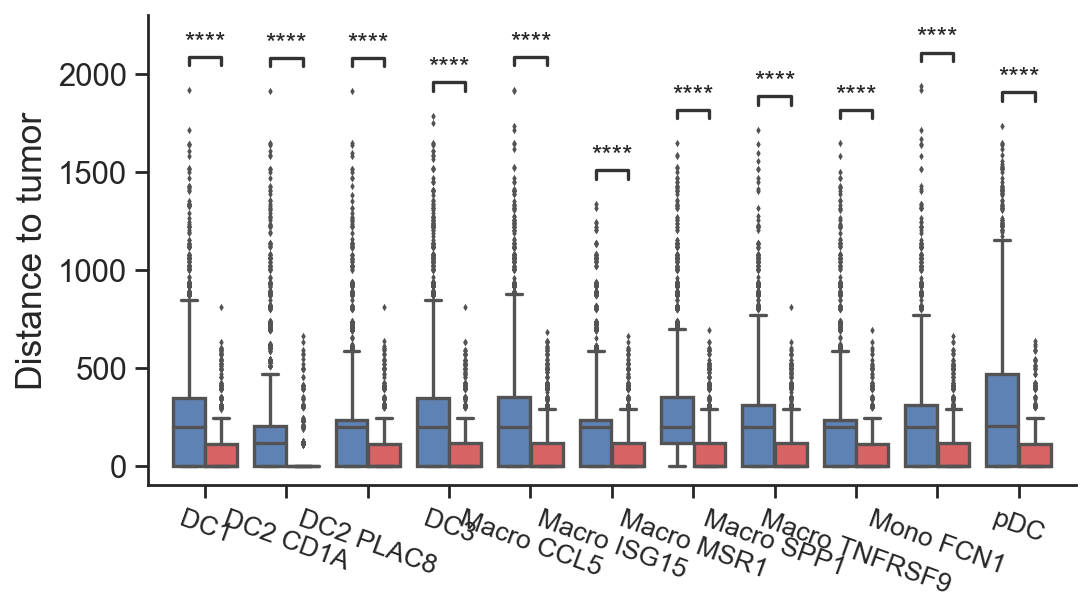

In [51]:
#sns.set(style="ticks")
my_pal ={'P':'#5f82b5','R':'#D76364'}
x = "celltype"
y = "distance"
data_boxplot = dist_df
#order = list(set(data_boxplot['cell_type']))
sc.set_figure_params(scanpy=True, fontsize=16)
sns.set(font='Arial',style="ticks")
with rc_context({'figure.figsize': (7, 4)}):
    ax = sns.boxplot(data=data_boxplot, x=x, y=data_boxplot['distance'], hue='type',fliersize=1, palette=my_pal, saturation=1)
    sns.despine(top = True, right = True)
    #ax.axes.set_title("Title",fontsize=16)
    ax.set(xlabel=None)
    ax.set_ylabel("Distance to tumor",fontsize=16)
    plt.legend([], frameon=False)
    ax.tick_params(labelsize=12, rotation=340,axis='x')
    ax.tick_params(labelsize=14, axis='y')
    add_stat_annotation(ax, data=data_boxplot, x=x, y=y, hue='type',
                        box_pairs=box_pairs,
                       test='Mann-Whitney', loc='inside',
                        comparisons_correction = None,
                       )
plt.tight_layout()    

In [35]:
data_boxplot['type'] = data_boxplot['type'].replace('P', 'PT')
data_boxplot['type'] = data_boxplot['type'].replace('R', 'RT')

In [36]:
data_boxplot.columns = ['cell type','distance to tumor','patient type']

### The correlation between SIRPA expression and distance from the tumor

In [25]:
pri_df_dict = {}
rec_df_dict = {}
for k in tqdm(range(len(sample_list))):
    sample = sample_list[k]
    sc_sample = scRNA_sample_list[k]
    adata_st = sc.read_visium(path+sample)
    adata_st.var_names_make_unique()
    sc.pp.normalize_per_cell(adata_st)
    sc.pp.log1p(adata_st)
    result = pd.read_csv('E:\\deconv\\SpaCET\\save_100\\'+sample+'_propMat.csv',index_col=0)
    result = result.T
    df_mal = result['Malignant']
    df_mal[df_mal>0.5] = 1
    df_mal[df_mal<=0.5] = 0
    Malignant_barcode_list = df_mal[df_mal==1].index
    
    spot_num = result.shape[0]
    spot_num_85 = int(spot_num*0.85)
    spot_num_15 = spot_num - spot_num_85 
    #random_distance = []
    #random_index = random.sample(range(spot_num), spot_num_15)
    #random_barcode_list = result.index[random_index]
    #dist_array, random_distance = calc_distance(adata_st, Malignant_barcode_list, random_barcode_list, method='total') 
    for celltype in ['DC2 CD1A','DC2 PLAC8','Mono FCN1','Macro SPP1','Macro CCL5','Macro MSR1','Macro ISG15','Macro TNFRSF9']:
        df_sorted = result[celltype].sort_values()
        df_top_15 = df_sorted[spot_num_85:]#select spots  with top 15% of celltype
        Myeloid_celltype_barcode_list = df_top_15.index
        dist_array, distance = calc_distance(adata_st, Myeloid_celltype_barcode_list, Malignant_barcode_list, method='total') 
        SIRPA_df = adata_st[Myeloid_celltype_barcode_list,'SIRPA'].to_df()
        SIRPA_df['distance'] = distance
        if scRNA_sample_list[k] in Pri_list:
            if celltype in pri_df_dict.keys():
                pri_df_dict[celltype] = pd.concat([pri_df_dict[celltype], SIRPA_df])
            else:
                pri_df_dict[celltype] = SIRPA_df
        else:
            if celltype in rec_df_dict.keys():
                rec_df_dict[celltype] = pd.concat([rec_df_dict[celltype], SIRPA_df])
            else:
                rec_df_dict[celltype] = SIRPA_df

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:13<00:00,  1.09it/s]


In [26]:
for celltype in ['DC2 CD1A','DC2 PLAC8','Mono FCN1','Macro SPP1','Macro CCL5','Macro MSR1','Macro ISG15','Macro TNFRSF9']:
    df_pri = pri_df_dict[celltype]
    sta_pri, corr_pri = pearsonr(df_pri['SIRPA'], df_pri['distance'])
    df_rec = rec_df_dict[celltype]
    sta_rec, corr_rec = pearsonr(df_rec['SIRPA'], df_rec['distance'])
    print(celltype, sta_pri, corr_pri, sta_rec, corr_rec)

DC2 CD1A -0.019423853874548657 0.22327407910399882 -0.06268594703074026 0.0007875136366071815
DC2 PLAC8 0.01315103146982169 0.4096427504488753 -0.03603788146811853 0.053763476402032495
Mono FCN1 0.017101186321886213 0.2836234532886556 -0.028565675912496334 0.12635313384951236
Macro SPP1 0.0302224962378416 0.058066836298952366 0.028584577955965643 0.12610233041710367
Macro CCL5 -0.03759885226615402 0.01837147042941248 -0.13382439889752717 6.371330068854071e-13
Macro MSR1 0.0436841358295459 0.00614339377151798 -0.0905010460510143 1.2223709155471282e-06
Macro ISG15 0.13087873543452194 1.711483630961417e-16 -0.08613924175646864 3.888877060047078e-06
Macro TNFRSF9 0.06785760589637009 2.0520198945992266e-05 -0.03181887826917434 0.08860260463312512


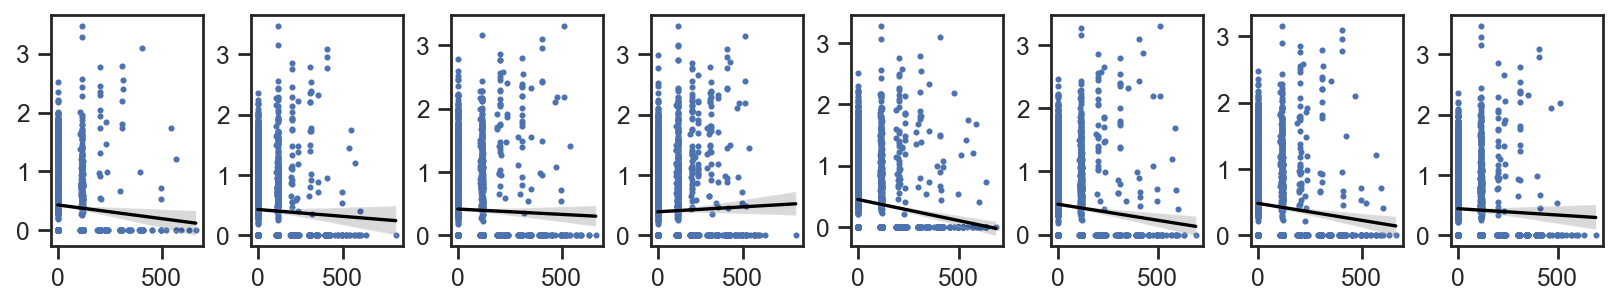

In [27]:
celltypes = ['DC2 CD1A','DC2 PLAC8','Mono FCN1','Macro SPP1','Macro CCL5','Macro MSR1','Macro ISG15','Macro TNFRSF9']
fig, axs = plt.subplots(1,8, figsize=(10,1.8),constrained_layout=True)
for i in range(len(celltypes)):
    celltype = celltypes[i]
    df_rec = rec_df_dict[celltype]
    sta_rec, corr_rec = pearsonr(df_rec['SIRPA'], df_rec['distance'])
    g = sns.regplot(x="distance", y='SIRPA', data=df_rec, ci=95, scatter_kws={"s": 3, "alpha": 1,}, 
                line_kws={'color': 'black','lw': 1.5}, ax=axs[i])
    g.set(xlabel=None)
    g.set(ylabel=None)
plt.savefig('SIRPA_distance_corr.svg')
plt.show()

#### Define CD47+ Malignant cells

In [28]:
def fdr(p_vals):

    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1

    return fdr

In [29]:
def CD47_Malignant_cells(adata_st, Malignant_barcode_list):
    barcode_list = []
    p_value_list = []
    CD47_Malignant_barcode_list = []
    CD47_Malignant_df = adata_st[Malignant_barcode_list,'CD47'].to_df()
    for barcode in Malignant_barcode_list:
        CD47_express_except_barcode = CD47_Malignant_df.loc[~(CD47_Malignant_df.index==barcode),:]
        CD47_express = adata_st[barcode, 'CD47'].X.toarray()[0][0]
        sta, p_value = wilcoxon(np.array(CD47_express_except_barcode).flatten()-CD47_express, alternative='less')
        p_value_list.append(p_value)
    fdr_list = fdr(np.array(p_value_list))
    for i in range(len(Malignant_barcode_list)):
        if fdr_list[i]<0.05:
            CD47_Malignant_barcode_list.append(Malignant_barcode_list[i])

    return CD47_Malignant_barcode_list

In [30]:
pri_df_dict = {}
rec_df_dict = {}
for k in tqdm(range(len(sample_list))):
    sample = sample_list[k]
    sc_sample = scRNA_sample_list[k]
    adata_st = sc.read_visium(path+sample)
    adata_st.var_names_make_unique()
    sc.pp.normalize_per_cell(adata_st)
    sc.pp.log1p(adata_st)
    result = pd.read_csv('E:\\deconv\\SpaCET\\save_100\\'+sample+'_propMat.csv',index_col=0)
    result = result.T
    df_mal = result['Malignant']
    df_mal[df_mal>0.5] = 1
    df_mal[df_mal<=0.5] = 0
    Malignant_barcode_list = df_mal[df_mal==1].index
    Malignant_barcode_list_CD47 = CD47_Malignant_cells(adata_st, Malignant_barcode_list)
    print(len(Malignant_barcode_list), len(Malignant_barcode_list_CD47))
    spot_num = result.shape[0]
    spot_num_85 = int(spot_num*0.85)
    spot_num_15 = spot_num - spot_num_85  
    for celltype in ['DC2 CD1A','DC2 PLAC8','Mono FCN1','Macro SPP1','Macro CCL5','Macro MSR1','Macro ISG15','Macro TNFRSF9']:
        df_sorted = result[celltype].sort_values()
        df_top_15 = df_sorted[spot_num_85:]#select spots  with top 15% of celltype
        Myeloid_celltype_barcode_list = df_top_15.index
        dist_array, distance = calc_distance(adata_st, Myeloid_celltype_barcode_list, Malignant_barcode_list_CD47, method='total') 
        SIRPA_df = adata_st[Myeloid_celltype_barcode_list,'SIRPA'].to_df()
        SIRPA_df['distance'] = distance
        if scRNA_sample_list[k] in Pri_list:
            if celltype in pri_df_dict.keys():
                pri_df_dict[celltype] = pd.concat([pri_df_dict[celltype], SIRPA_df])
            else:
                pri_df_dict[celltype] = SIRPA_df
        else:
            if celltype in rec_df_dict.keys():
                rec_df_dict[celltype] = pd.concat([rec_df_dict[celltype], SIRPA_df])
            else:
                rec_df_dict[celltype] = SIRPA_df

  7%|█████▌                                                                             | 1/15 [00:03<00:50,  3.57s/it]

2477 1258


 13%|███████████                                                                        | 2/15 [00:05<00:33,  2.58s/it]

886 432


 20%|████████████████▌                                                                  | 3/15 [00:08<00:32,  2.72s/it]

1688 864


 27%|██████████████████████▏                                                            | 4/15 [00:10<00:29,  2.64s/it]

1406 696


 33%|███████████████████████████▋                                                       | 5/15 [00:12<00:24,  2.45s/it]

1996 709


 40%|█████████████████████████████████▏                                                 | 6/15 [00:14<00:19,  2.18s/it]

1435 398


 47%|██████████████████████████████████████▋                                            | 7/15 [00:16<00:17,  2.23s/it]

2085 1025


 53%|████████████████████████████████████████████▎                                      | 8/15 [00:19<00:16,  2.29s/it]

2117 779


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:21<00:14,  2.36s/it]

2001 997


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:24<00:12,  2.44s/it]

1789 882


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [00:26<00:08,  2.18s/it]

764 379


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [00:28<00:06,  2.20s/it]

1672 848


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [00:30<00:04,  2.07s/it]

1120 567


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:34<00:02,  2.69s/it]

2828 1438


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:36<00:00,  2.42s/it]

1378 676


In [31]:
for celltype in ['DC2 CD1A','DC2 PLAC8','Mono FCN1','Macro SPP1','Macro CCL5','Macro MSR1','Macro ISG15','Macro TNFRSF9']:
    df_pri = pri_df_dict[celltype]
    sta_pri, corr_pri = spearmanr(df_pri['SIRPA'], df_pri['distance'])
    df_rec = rec_df_dict[celltype]
    sta_rec, corr_rec = spearmanr(df_rec['SIRPA'], df_rec['distance'])
    print(celltype, sta_pri, corr_pri, sta_rec, corr_rec)

DC2 CD1A -0.06027648434129816 0.00015532652469521114 -0.17261744916004623 1.335282700479889e-20
DC2 PLAC8 -0.03982843285570712 0.012490220293655149 -0.16946439365828625 6.670652437360985e-20
Mono FCN1 -0.0713928373059547 7.4085374166510495e-06 -0.16803000311752653 1.3726391869299492e-19
Macro SPP1 -0.049881506171253066 0.0017528048954107574 -0.13056696057158132 2.288188246659354e-12
Macro CCL5 -0.07224132735153992 5.760291321123347e-06 -0.24764701710699094 2.6932186851197725e-41
Macro MSR1 -0.0033021711322779768 0.8359896383899864 -0.2062528408468781 6.757520805651142e-29
Macro ISG15 0.043312587953990345 0.006593609616200705 -0.20390892188253873 2.8747526423273494e-28
Macro TNFRSF9 0.0009867885051895453 0.9506699915023943 -0.16562442000696095 4.538870034410089e-19


In [27]:
for celltype in ['DC2 CD1A','DC2 PLAC8','Mono FCN1','Macro SPP1','Macro CCL5','Macro MSR1','Macro ISG15','Macro TNFRSF9']:
    df_pri = pri_df_dict[celltype]
    sta_pri, corr_pri = spearmanr(df_pri['SIRPA'], df_pri['distance'])
    df_rec = rec_df_dict[celltype]
    sta_rec, corr_rec = spearmanr(df_rec['SIRPA'], df_rec['distance'])
    print(celltype, sta_pri, corr_pri)

DC2 CD1A -0.06027648434129816 0.00015532652469521114
DC2 PLAC8 -0.03982843285570712 0.012490220293655149
Mono FCN1 -0.0713928373059547 7.408537416651049e-06
Macro SPP1 -0.049881506171253066 0.0017528048954107574
Macro CCL5 -0.07224132735153992 5.760291321123347e-06
Macro MSR1 -0.0033021711322779768 0.8359896383899864
Macro ISG15 0.043312587953990345 0.006593609616200705
Macro TNFRSF9 0.0009867885051895453 0.9506699915023943


In [28]:
for celltype in ['DC2 CD1A','DC2 PLAC8','Mono FCN1','Macro SPP1','Macro CCL5','Macro MSR1','Macro ISG15','Macro TNFRSF9']:
    df_pri = pri_df_dict[celltype]
    sta_pri, corr_pri = spearmanr(df_pri['SIRPA'], df_pri['distance'])
    df_rec = rec_df_dict[celltype]
    sta_rec, corr_rec = spearmanr(df_rec['SIRPA'], df_rec['distance'])
    print(celltype, sta_rec, corr_rec)

DC2 CD1A -0.17261744916004623 1.335282700479889e-20
DC2 PLAC8 -0.16946439365828625 6.670652437360985e-20
Mono FCN1 -0.16803000311752653 1.372639186929949e-19
Macro SPP1 -0.13056696057158132 2.288188246659354e-12
Macro CCL5 -0.24764701710699094 2.693218685119773e-41
Macro MSR1 -0.2062528408468781 6.757520805651142e-29
Macro ISG15 -0.20390892188253873 2.8747526423273494e-28
Macro TNFRSF9 -0.16562442000696095 4.538870034410089e-19


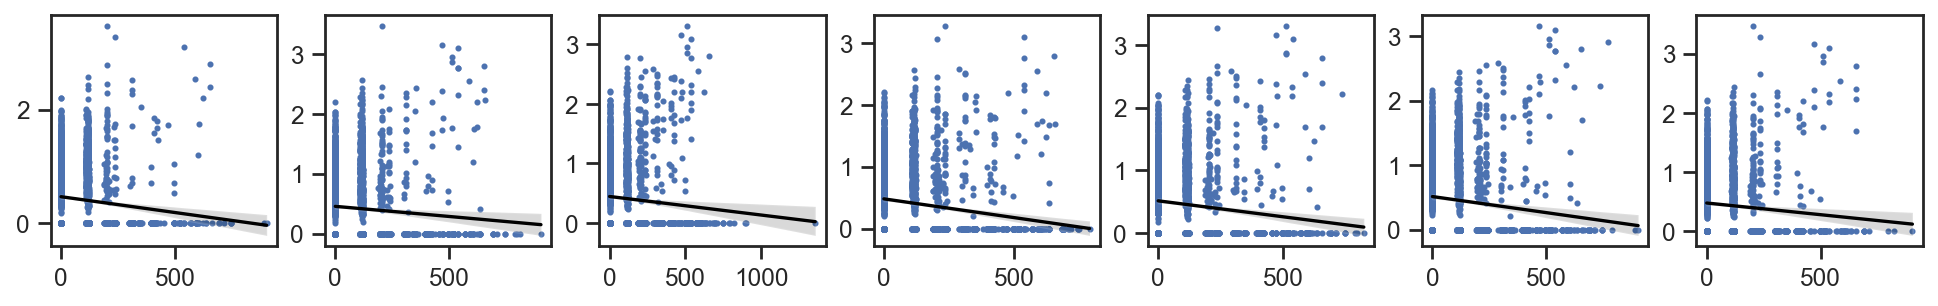

In [22]:
celltypes = ['DC2 CD1A','DC2 PLAC8','Mono FCN1','Macro CCL5','Macro MSR1','Macro ISG15','Macro TNFRSF9']
fig, axs = plt.subplots(1,7, figsize=(12,1.8),constrained_layout=True)
for i in range(len(celltypes)):
    celltype = celltypes[i]
    df_rec = rec_df_dict[celltype]
    sta_rec, corr_rec = pearsonr(df_rec['SIRPA'], df_rec['distance'])
    g = sns.regplot(x="distance", y='SIRPA', data=df_rec, ci=95, scatter_kws={"s": 3, "alpha": 1,}, 
                line_kws={'color': 'black','lw': 1.5}, ax=axs[i])
    g.set(xlabel=None)
    g.set(ylabel=None)
plt.savefig('SIRPA_CD47_distance_corr_rec.svg')
plt.show()

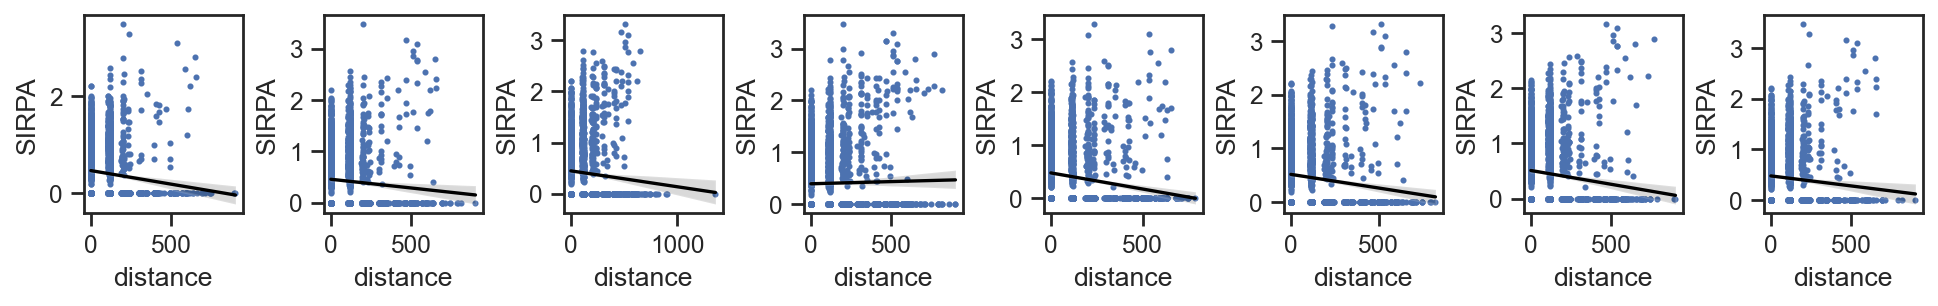

In [23]:
celltypes = ['DC2 CD1A','DC2 PLAC8','Mono FCN1','Macro SPP1','Macro CCL5','Macro MSR1','Macro ISG15','Macro TNFRSF9']
fig, axs = plt.subplots(1,8, figsize=(12,1.8),constrained_layout=True)
for i in range(len(celltypes)):
    celltype = celltypes[i]
    df_rec = rec_df_dict[celltype]
    sta_rec, corr_rec = pearsonr(df_rec['SIRPA'], df_rec['distance'])
    g = sns.regplot(x="distance", y='SIRPA', data=df_rec, ci=95, scatter_kws={"s": 3, "alpha": 1,}, 
                line_kws={'color': 'black','lw': 1.5}, ax=axs[i])
    #g.set(xlabel=None)
    #g.set(ylabel=None)
#plt.savefig('SIRPA_CD47_distance_corr.svg')
plt.show()

### pri corr distance

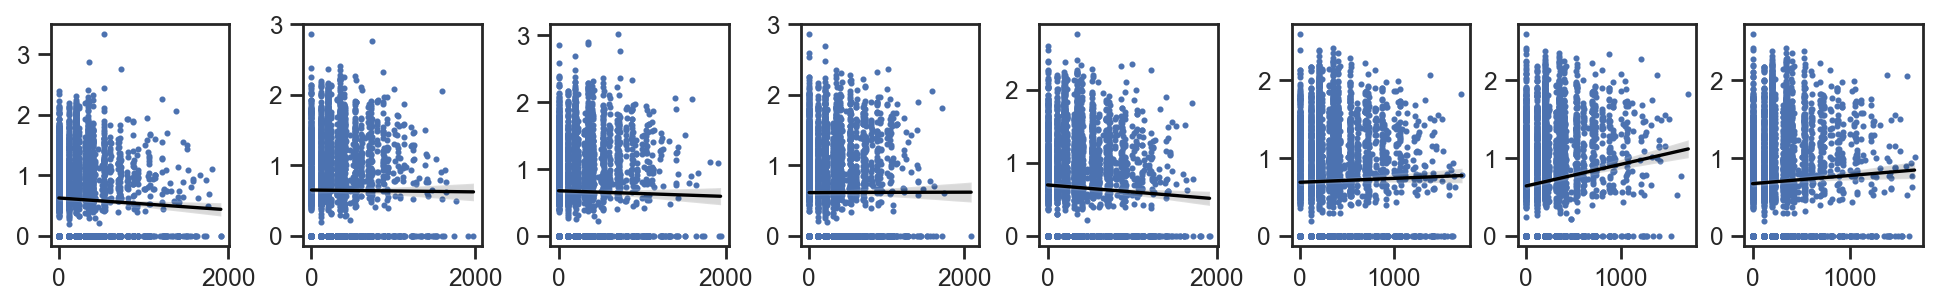

In [24]:
celltypes = ['DC2 CD1A','DC2 PLAC8','Mono FCN1','Macro SPP1','Macro CCL5','Macro MSR1','Macro ISG15','Macro TNFRSF9']
fig, axs = plt.subplots(1,8, figsize=(12,1.8),constrained_layout=True)
for i in range(len(celltypes)):
    celltype = celltypes[i]
    df_pri = pri_df_dict[celltype]
    sta_pri, corr_pri = pearsonr(df_pri['SIRPA'], df_pri['distance'])
    g = sns.regplot(x="distance", y='SIRPA', data=df_pri, ci=95, scatter_kws={"s": 3, "alpha": 1,}, 
                line_kws={'color': 'black','lw': 1.5}, ax=axs[i])
    g.set(xlabel=None)
    g.set(ylabel=None)
#plt.savefig('SIRPA_CD47_distance_corr_pri.svg')
plt.show()

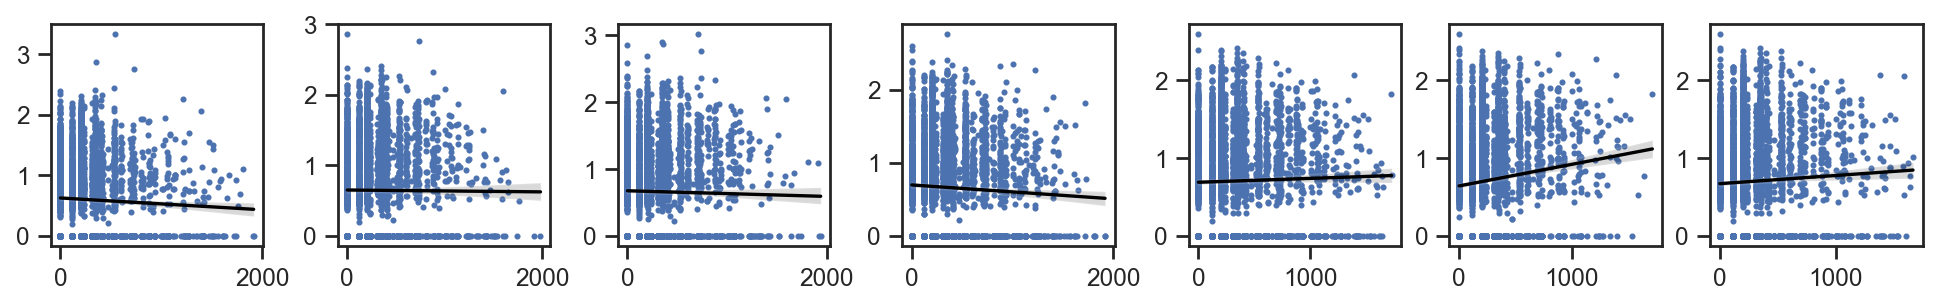

In [25]:
celltypes = ['DC2 CD1A','DC2 PLAC8','Mono FCN1','Macro CCL5','Macro MSR1','Macro ISG15','Macro TNFRSF9']
fig, axs = plt.subplots(1,7, figsize=(12,1.8),constrained_layout=True)
for i in range(len(celltypes)):
    celltype = celltypes[i]
    df_pri = pri_df_dict[celltype]
    sta_pri, corr_pri = pearsonr(df_pri['SIRPA'], df_pri['distance'])
    g = sns.regplot(x="distance", y='SIRPA', data=df_pri, ci=95, scatter_kws={"s": 3, "alpha": 1,}, 
                line_kws={'color': 'black','lw': 1.5}, ax=axs[i])
    g.set(xlabel=None)
    g.set(ylabel=None)
plt.savefig('SIRPA_CD47_distance_corr_pri.svg')
plt.show()